In [1]:
import numpy as np
import pylab as plt
from glob import glob
import os
from fnmatch import filter
from scipy.stats import zscore, mode
import pymc3 as pm
from theano import tensor as tt
from sklearn.impute import SimpleImputer
from scipy.ndimage import gaussian_filter1d as gauss_filt

In [2]:
data_dir = '/media/fastdata/brad_changepoint/raw_data/'

In [3]:
file_list = glob(os.path.join(data_dir,"*.npy"))
lfp_files = [x for x in file_list if 'rear' not in x]
rear_files = [x for x in file_list if 'rear' in x]

In [4]:
load_groups = [['cons1','cons2'],['exps1','expl1']]
rear_groups = [[[x for x in rear_files if name in x] for name in group] for group in load_groups]
rear_groups = np.squeeze(np.array(rear_groups))

In [5]:
rear_dat = np.array([[np.load(x,'r')[:] for x in group] for group in rear_groups])
zscore_rear_dat = np.array([[zscore(x,axis=-1) for x in group] for group in rear_dat])
imputer = SimpleImputer(strategy = 'constant', fill_value = 0)
inds = np.ndindex(zscore_rear_dat.shape)
for this_ind in inds:
    zscore_rear_dat[this_ind] = imputer.fit_transform(zscore_rear_dat[this_ind])

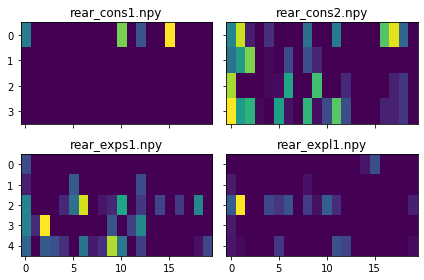

In [6]:
inds = list(np.ndindex(rear_dat.shape))
fig,ax = plt.subplots(2,2,sharex=True, sharey = 'row')
for this_ind in inds:
    ax[this_ind].imshow(rear_dat[this_ind],aspect='auto')
    ax[this_ind].set_title(os.path.basename(rear_groups[this_ind]))
plt.tight_layout()

In [7]:
exp_diff_rear_raw = np.diff(rear_dat[1], axis=0)[0]
con_diff_rear_raw = np.diff(rear_dat[0], axis=0)[0]

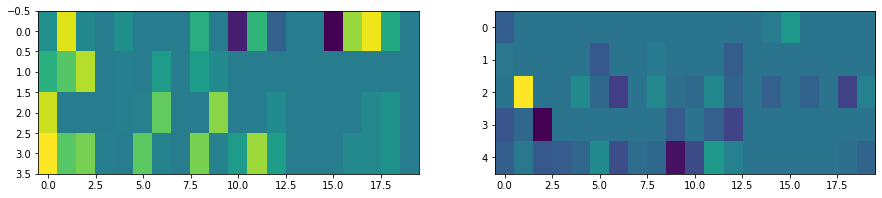

In [8]:
fig,ax = plt.subplots(1,2, figsize = (15,3))
ax[0].imshow(con_diff_rear_raw,aspect='auto');
ax[1].imshow(exp_diff_rear_raw,aspect='auto');

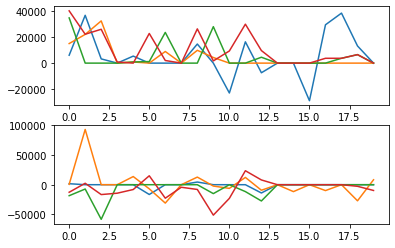

In [9]:
fig,ax = plt.subplots(2,1)
ax[0].plot(con_diff_rear_raw.T);
ax[1].plot(exp_diff_rear_raw[1:].T);

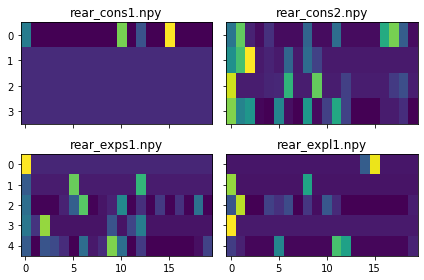

In [10]:
inds = list(np.ndindex(rear_dat.shape))
fig,ax = plt.subplots(2,2,sharex=True, sharey = 'row')
for this_ind in inds:
    ax[this_ind].imshow(zscore_rear_dat[this_ind],aspect='auto')
    ax[this_ind].set_title(os.path.basename(rear_groups[this_ind]))
plt.tight_layout()

In [11]:
# Within animal subtraction first, then within animal zscore
exp_diff_rear = zscore(np.diff(rear_dat[1], axis=0)[0], axis=-1)
con_diff_rear = zscore(np.diff(rear_dat[0], axis=0)[0], axis=-1)

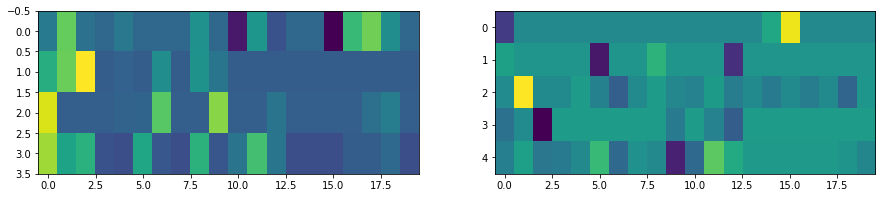

In [12]:
fig,ax = plt.subplots(1,2, figsize = (15,3))
ax[0].imshow(con_diff_rear,aspect='auto');
ax[1].imshow(exp_diff_rear,aspect='auto');

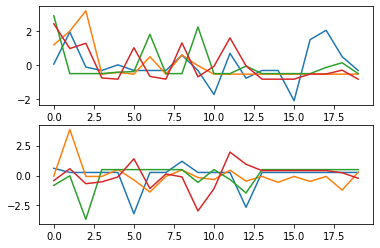

In [13]:
fig,ax = plt.subplots(2,1)
ax[0].plot(con_diff_rear.T);
ax[1].plot(exp_diff_rear[1:].T);

# 2 state model

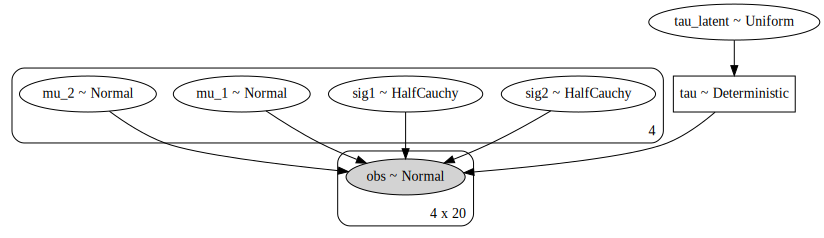

In [14]:
with pm.Model() as con_model:
    # Defining variables with priors
    mu_1 = pm.Normal("mu_1", mu=0, sigma = 1, shape = con_diff_rear.shape[0])
    mu_2 = pm.Normal("mu_2", mu=0, sigma = 1, shape = con_diff_rear.shape[0])
    sigma1 = pm.HalfCauchy('sig1', 1, shape = con_diff_rear.shape[0])
    sigma2 = pm.HalfCauchy('sig2', 1, shape = con_diff_rear.shape[0])
    
    idx = np.arange(con_diff_rear.shape[-1])
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1, testval = 0.5)
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))[np.newaxis,:]
    mu_ = (1 - weight) * mu_1[:,np.newaxis] + weight * mu_2[:,np.newaxis]
    sigma_ = (1 - weight) * sigma1[:,np.newaxis] + weight * sigma2[:,np.newaxis]

    observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=con_diff_rear)

pm.model_to_graphviz(con_model)

In [15]:
with pm.Model() as exp_model:
    # Defining variables with priors
    mu_1 = pm.Normal("mu_1", mu=0, sigma = 1, shape = exp_diff_rear.shape[0])
    mu_2 = pm.Normal("mu_2", mu=0, sigma = 1, shape = exp_diff_rear.shape[0])
    sigma1 = pm.HalfCauchy('sig1', 1, shape = exp_diff_rear.shape[0])
    sigma2 = pm.HalfCauchy('sig2', 1, shape = exp_diff_rear.shape[0])
    
    idx = np.arange(exp_diff_rear.shape[-1])
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1, testval = 0.5)
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))[np.newaxis,:]
    mu_ = (1 - weight) * mu_1[:,np.newaxis] + weight * mu_2[:,np.newaxis]
    sigma_ = (1 - weight) * sigma1[:,np.newaxis] + weight * sigma2[:,np.newaxis]

    observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=exp_diff_rear)

In [16]:
sample_kwargs = {'draws' : 50000, 'tune' : 2000, 'chains' : 8, 'cores' : 8}

In [17]:
with con_model:
    con_trace = pm.sample(**sample_kwargs, step = pm.Metropolis())
with exp_model:
    exp_trace = pm.sample(**sample_kwargs, step = pm.Metropolis())

Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 8 chains, 0 divergences: 100%|██████████| 416000/416000 [01:14<00:00, 5559.78draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 8 chains, 0 divergences: 100%|██████████| 416000/416000 [01:16<00:00, 5412.23draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [18]:
# pm.traceplot(con_trace[::100]);

In [19]:
# pm.traceplot(exp_trace[::100]);

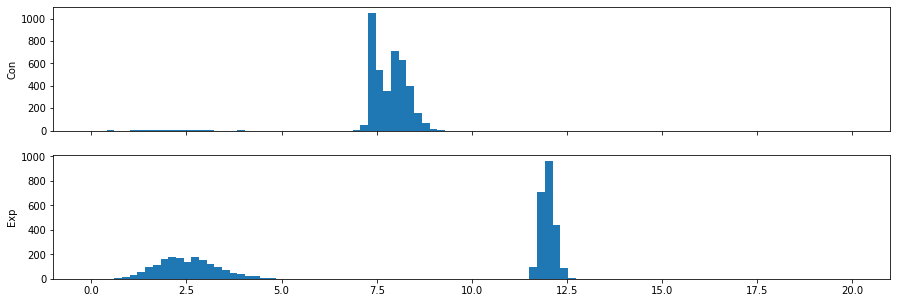

In [20]:
thinning = 100
con_tau_array = np.array(con_trace['tau'][::thinning])
exp_tau_array = np.array(exp_trace['tau'][::thinning])

bins = np.linspace(0,20,100)
fig, ax = plt.subplots(2,1, figsize = (15,5), sharex=True)
ax[0].hist(con_tau_array, bins);
ax[1].hist(exp_tau_array, bins);

ax[0].set_ylabel('Con');
ax[1].set_ylabel('Exp');

# 3 State Model

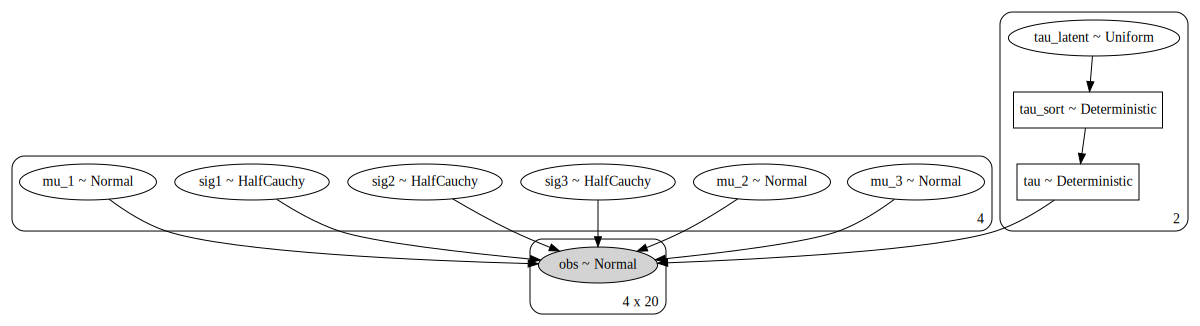

In [21]:
with pm.Model() as con_model:
    # Defining variables with priors
    mu_1 = pm.Normal("mu_1", mu=0, sigma = 1, shape = con_diff_rear.shape[0])
    mu_2 = pm.Normal("mu_2", mu=0, sigma = 1, shape = con_diff_rear.shape[0])
    mu_3 = pm.Normal("mu_3", mu=0, sigma = 1, shape = con_diff_rear.shape[0])
    sigma1 = pm.HalfCauchy('sig1', 1, shape = con_diff_rear.shape[0])
    sigma2 = pm.HalfCauchy('sig2', 1, shape = con_diff_rear.shape[0])
    sigma3 = pm.HalfCauchy('sig3', 1, shape = con_diff_rear.shape[0])
    
    idx = np.arange(con_diff_rear.shape[-1])
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1, shape = 2, testval = [0.3,0.6])
    tau_sort = pm.Deterministic('tau_sort', tau_latent.sort())
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_sort)
    
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight1 = tt.nnet.sigmoid(2 * (idx - tau[0]))[np.newaxis,:]
    weight2 = tt.nnet.sigmoid(2 * (idx - tau[1]))[np.newaxis,:]
    mu_ = (1 - weight1) * mu_1[:,np.newaxis] + (weight1*(1-weight2)) * mu_2[:,np.newaxis] + weight2 * mu_3[:,np.newaxis]
    sigma_ = (1 - weight1) * sigma1[:,np.newaxis] + (weight1*(1-weight2)) * sigma2[:,np.newaxis] + weight2 * sigma3[:,np.newaxis]
    
    observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=con_diff_rear)

pm.model_to_graphviz(con_model)

In [22]:
with pm.Model() as exp_model:
    # Defining variables with priors
    mu_1 = pm.Normal("mu_1", mu=0, sigma = 1, shape = exp_diff_rear.shape[0])
    mu_2 = pm.Normal("mu_2", mu=0, sigma = 1, shape = exp_diff_rear.shape[0])
    mu_3 = pm.Normal("mu_3", mu=0, sigma = 1, shape = exp_diff_rear.shape[0])
    sigma1 = pm.HalfCauchy('sig1', 1, shape = exp_diff_rear.shape[0])
    sigma2 = pm.HalfCauchy('sig2', 1, shape = exp_diff_rear.shape[0])
    sigma3 = pm.HalfCauchy('sig3', 1, shape = exp_diff_rear.shape[0])
    
    idx = np.arange(exp_diff_rear.shape[-1])
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1, shape = 2, testval = [0.3,0.6])
    tau_sort = pm.Deterministic('tau_sort', tau_latent.sort())
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_sort)
    
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight1 = tt.nnet.sigmoid(2 * (idx - tau[0]))[np.newaxis,:]
    weight2 = tt.nnet.sigmoid(2 * (idx - tau[1]))[np.newaxis,:]
    mu_ = (1 - weight1) * mu_1[:,np.newaxis] + (weight1*(1-weight2)) * mu_2[:,np.newaxis] + weight2 * mu_3[:,np.newaxis]
    sigma_ = (1 - weight1) * sigma1[:,np.newaxis] + (weight1*(1-weight2)) * sigma2[:,np.newaxis] + weight2 * sigma3[:,np.newaxis]
    
    observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=exp_diff_rear)

In [23]:
with con_model:
    con3_trace = pm.sample(**sample_kwargs, step = pm.Metropolis())
with exp_model:
    exp3_trace = pm.sample(**sample_kwargs, step = pm.Metropolis())

Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig3]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_3]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 8 chains, 0 divergences: 100%|██████████| 416000/416000 [01:58<00:00, 3517.32draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig3]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_3]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 8 chains, 0 divergences: 100%|██████████| 416000/416000 [01:58<00:00, 3496.80draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [24]:
# pm.traceplot(con3_trace[::100]);

In [25]:
# pm.traceplot(exp3_trace[::100]);

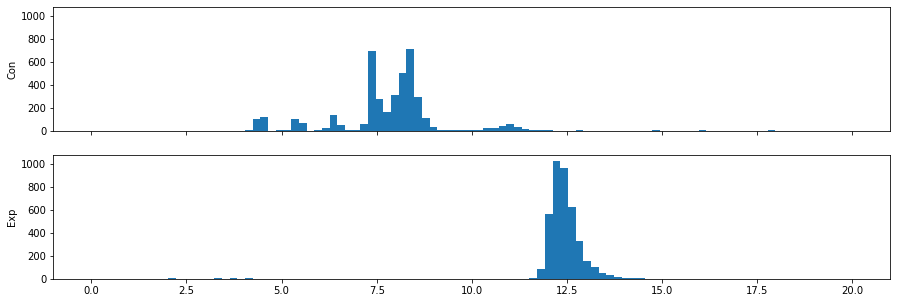

In [26]:
thinning = 100
con_tau_array = np.array(con3_trace['tau'][::thinning])[:,1]
exp_tau_array = np.array(exp3_trace['tau'][::thinning])[:,1]

bins = np.linspace(0,20,100)
fig, ax = plt.subplots(2,1, figsize = (15,5), sharex=True, sharey=True)
ax[0].hist(con_tau_array, bins);
ax[1].hist(exp_tau_array, bins);

ax[0].set_ylabel('Con');
ax[1].set_ylabel('Exp');

#  Changepoint on difference between conditions

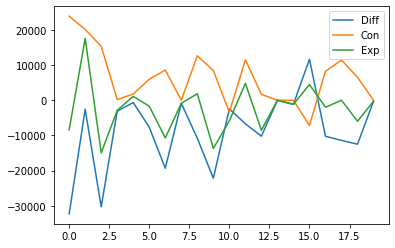

In [59]:
mean_con_diff_rear = np.mean(con_diff_rear_raw,axis=0)
mean_exp_diff_rear = np.mean(exp_diff_rear_raw, axis=0)
diff_diff_rear = mean_exp_diff_rear - mean_con_diff_rear
#diff_diff_rear -= np.min(diff_diff_rear)
plt.plot(diff_diff_rear, label = 'Diff')
plt.plot(mean_con_diff_rear, label = 'Con')
plt.plot(mean_exp_diff_rear, label = 'Exp')
plt.legend()

In [57]:
# mean_con_diff_rear = np.mean(rear_dat[0,1],axis=0)
# mean_exp_diff_rear = np.mean(rear_dat[1,1], axis=0)
# diff_diff_rear = mean_exp_diff_rear - mean_con_diff_rear
# #diff_diff_rear -= np.min(diff_diff_rear)
# plt.plot(diff_diff_rear, label = 'Diff')
# # plt.plot(mean_con_diff_rear, label = 'Con')
# # plt.plot(mean_exp_diff_rear, label = 'Exp')
# plt.legend()

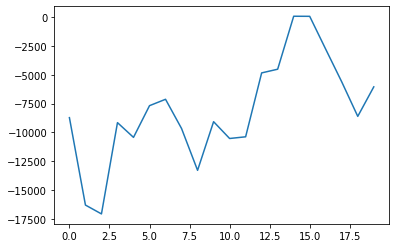

In [58]:
conv_diff_diff = np.convolve(diff_diff_rear, np.ones(4)/4, mode = 'same')
#conv_diff_diff = gauss_filt(diff_diff_rear, sigma = 1)
plt.plot(conv_diff_diff)

In [43]:
# with pm.Model() as diff_model:
#     # Defining variables with priors
#     mu_1 = pm.Normal("mu_1", mu=0, sigma = 1)
#     mu_2 = pm.Normal("mu_2", mu=0, sigma = 1)
#     sigma1 = pm.HalfCauchy('sig1', 1)
#     sigma2 = pm.HalfCauchy('sig2', 1)
    
#     idx = np.arange(len(conv_diff_diff))
    
#     # Uniform prior
#     tau_latent = pm.Uniform('tau_latent', 0, 1, testval = 0.5)
#     tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
#     # Using sigmoid rather than switch is supposed to be better
#     # for sampler
#     weight = tt.nnet.sigmoid(2 * (idx - tau))
#     mu_ = (1 - weight) * mu_1 + weight * mu_2
#     sigma_ = (1 - weight) * sigma1 + weight * sigma2

#     observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=conv_diff_diff)

In [44]:
with pm.Model() as sigmoid_model:
    # function = a/(1+ exp(-u(x-t))) + b
    # a and b determine base and max height
    # t determines inflection
    # u determines sharpness of inflection
    a = pm.Normal("a", mu=0, sigma = 1)
    b = pm.Normal("b", mu=0, sigma = 1)
    u = pm.HalfNormal("u", sigma = 1)
    t = pm.Uniform("t", 0,len(conv_diff_diff))
    
    idx = np.arange(len(conv_diff_diff))
    
    err = pm.HalfCauchy('err', 1)
    
    sigm = pm.Deterministic('sigm', a/(1+ np.exp(-u*(idx-t))) + b)
    observation = pm.Normal("obs", mu=sigm, sigma = err, observed=conv_diff_diff)

In [45]:
http://127.0.0.1:8080/?token=00a823f6d4aa8948a4bf54888dd5f714d59e6a56c320f91cwith pm.Model() as three_model:
    # Defining variables with priors
    mu_1 = pm.Normal("mu_1", mu=0, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=0, sigma = 1)
    mu_3 = pm.Normal("mu_3", mu=0, sigma = 1)
    
    idx = np.arange(len(conv_diff_diff))
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1, shape = 2, testval = [0.3,0.6])
    tau_sort = pm.Deterministic('tau_sort', tau_latent.sort())
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_sort)
    
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight1 = tt.nnet.sigmoid(2 * (idx - tau[0]))
    weight2 = tt.nnet.sigmoid(2 * (idx - tau[1]))
    mu_ = (1 - weight1) * mu_1 + (weight1*(1-weight2)) * mu_2 + weight2 * mu_3
    err = pm.HalfCauchy('err', 1)
    
    observation = pm.Normal("obs", mu=mu_, sigma = err, observed=conv_diff_diff)

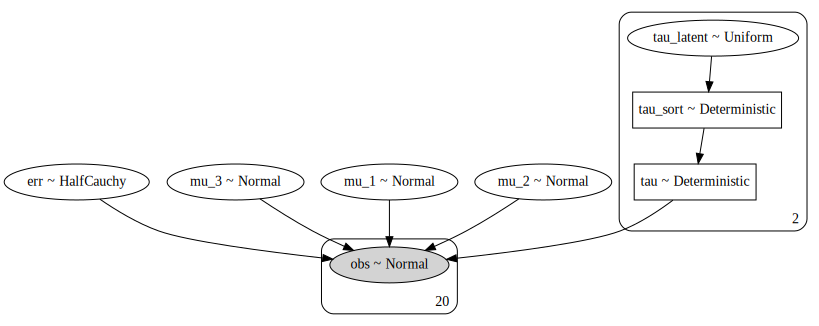

In [46]:
pm.model_to_graphviz(three_model)

In [47]:
sample_kwargs = {'draws' : 5000, 'tune' : 1000, 'chains' : 16, 'cores' : 16}

In [48]:
with three_model:
    diff_trace = pm.sample(**sample_kwargs, step = pm.Metropolis())

Multiprocess sampling (16 chains in 16 jobs)
CompoundStep
>Metropolis: [err]
>Metropolis: [tau_latent]
>Metropolis: [mu_3]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 16 chains, 0 divergences: 100%|██████████| 96000/96000 [00:18<00:00, 5271.23draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


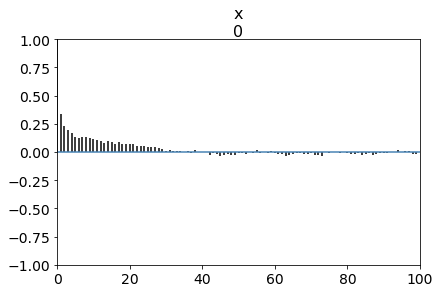

In [49]:
thinning = 10
pm.plot_autocorr(diff_trace['mu_1'][::thinning])
diff_trace_thin = diff_trace[::thinning] 

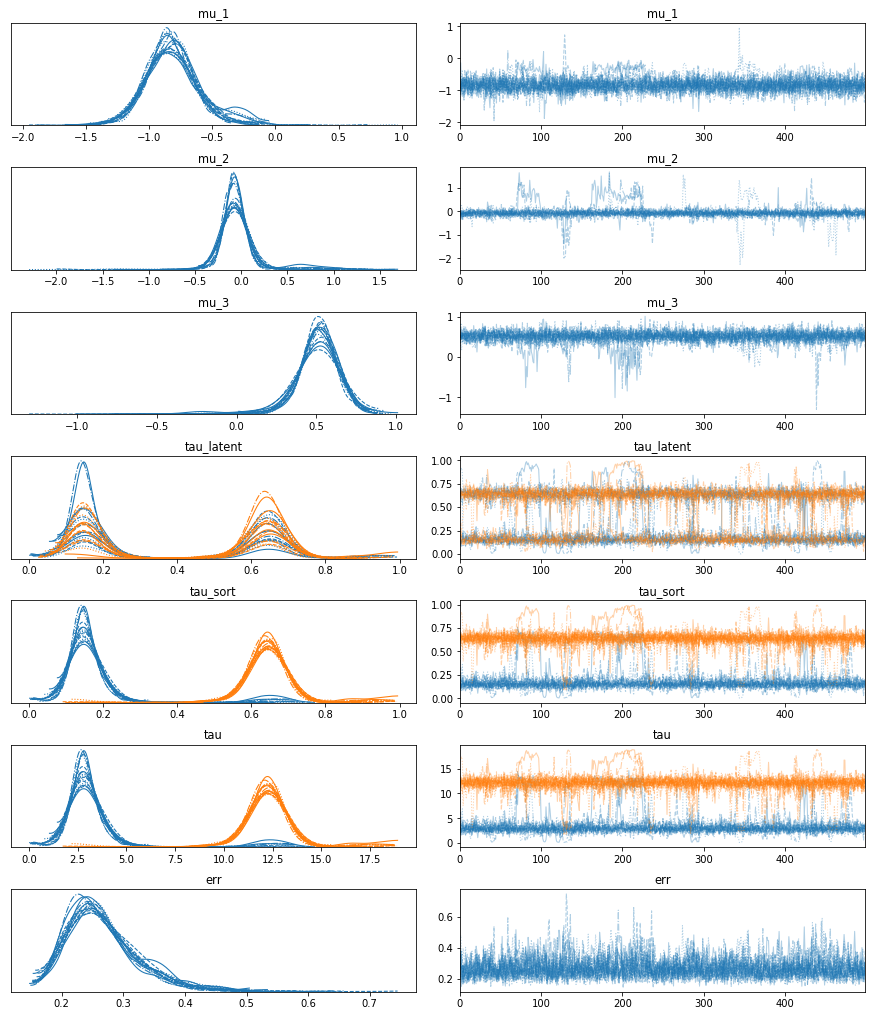

In [50]:
pm.traceplot(diff_trace_thin);

In [51]:
def ppc_func_custom(mu_1, mu_2, mu_3, tau, **kwargs):
    t = np.arange(0,len(conv_diff_diff), 0.1)
    ppc = np.zeros(len(t))
    #tau_int = np.round(tau, 1)
    ppc[np.where(t < tau[0])[0]] = mu_1
    ppc[np.where(np.array(t > tau[0])*np.array(t < tau[1]))[0]] = mu_2
    ppc[np.where(t > tau[1])[0]] = mu_3
    return t,ppc

In [52]:
t_s, outs = zip(*[ppc_func_custom(**x) for x in diff_trace_thin])
t_s = np.array(t_s)
outs = np.array(outs)

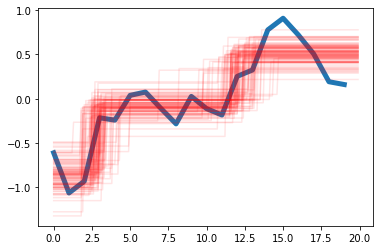

In [53]:
#ppc = pm.sample_posterior_predictive(diff_trace_thin, samples=1000, model=three_model)
plt.plot(conv_diff_diff, linewidth = 5);
jump = 5
for this_t, this_ppc in zip(t_s[::jump], outs[::jump]):
    plt.plot(this_t, this_ppc, alpha = 0.1, color='red');

In [54]:
# plt.plot(conv_diff_diff, linewidth = 5);
# plt.plot(diff_trace_thin['sigm'][::100].T, alpha = 0.1, color='red');

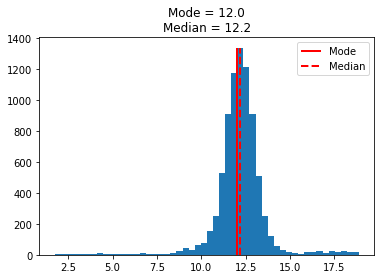

In [55]:
bins = 50
counts, vals = np.histogram(diff_trace_thin['tau'][:,1], bins = bins)
max_count = np.max(counts)
max_val = vals[np.argmax(counts)]
med_val = np.sort(diff_trace_thin['tau'][:,1])[np.int(len(diff_trace_thin['tau'][:,1])//2)]
plt.hist(diff_trace_thin['tau'][:,1], bins = bins);
plt.vlines(max_val, 0, max_count, linewidth = 2, color = 'red', label = 'Mode')
plt.vlines(med_val, 0, max_count, linewidth = 2, color = 'red', linestyle= '--', label = 'Median')
plt.title(f'Mode = {np.round(max_val,1)}' + '\n' + f'Median = {np.round(med_val,1)}')
plt.legend();

# Temporal Shuffled comparison

In [44]:
# #Temporal shuffle
# znormdiff_shuffle = np.array([np.random.permutation(x) for x in znormdiff_matrix]) 
# zdiff_shuffle_mean = np.nanmean(znormdiff_shuffle,axis=0)

# #count_data
# count_data_shuffle = np.sum(znormdiff_shuffle,axis=0)
# count_data_shuffle = zdiff_shuffle_mean
# n_count_data = len(count_data_shuffle)

# plt.imshow(znormdiff_shuffle,aspect='auto')
# plt.figure()
# plt.plot(count_data_shuffle)

In [45]:
# with pm.Model() as model:
#     # Defining variables with priors
#     alpha = count_data_shuffle.mean()  # Recall count_data is the
#                                    # variable that holds our txt counts
#     mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
#     mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
#     sigma1 = pm.HalfCauchy('sig1', 1, shape = znormdiff_matrix.shape[0])
#     sigma2 = pm.HalfCauchy('sig2', 1, shape = znormdiff_matrix.shape[0])

# with model:
#     idx = np.arange(n_count_data) # Index
    
#     # Scaled beta mixture "somewhere in the middle" prior
#     #a = 3
#     #b = 3
#     #tau_latent = pm.Beta('tau_latent', a, b)
    
#     # Uniform prior
#     tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    
#     tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
#     # Using sigmoid rather than switch is supposed to be better
#     # for sampler
#     weight = tt.nnet.sigmoid(2 * (idx - tau))[np.newaxis,:]
#     mu_ = (1 - weight) * mu_1[:,np.newaxis] + weight * mu_2[:,np.newaxis]
#     sigma_ = (1 - weight) * sigma1[:,np.newaxis] + weight * sigma2[:,np.newaxis]


# with model:
#     observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=znormdiff_shuffle)

# pm.model_to_graphviz(model)

In [46]:
# with model:
#     #step = pm.Slice()
#     step = pm.Metropolis()
#     trace = pm.sample(5000, tune=1000, 
#                     step = step,
#                       chains = 4, cores = 4)

In [47]:
# pm.traceplot(trace, varnames = ['tau']);

In [48]:
# ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)
# fig,ax=plt.subplots(2,1)
# ax[0].imshow(znormdiff_shuffle,aspect='auto')
# ax[1].imshow(np.mean(ppc['obs'],axis=0),aspect='auto')

# Random shuffle comparison

In [49]:
# #Temporal shuffle
# mat_shape = znormdiff_matrix.shape
# znormdiff_shuffle =  np.reshape(np.random.permutation(znormdiff_matrix.flatten()), mat_shape)
# zdiff_shuffle_mean = np.nanmean(znormdiff_shuffle,axis=0)

# #count_data
# count_data_shuffle = np.sum(znormdiff_shuffle,axis=0)
# count_data_shuffle = zdiff_shuffle_mean
# n_count_data = len(count_data_shuffle)

# plt.imshow(znormdiff_shuffle,aspect='auto')
# plt.figure()
# plt.plot(count_data_shuffle)

In [50]:
# with pm.Model() as model:
#     # Defining variables with priors
#     alpha = count_data_shuffle.mean()  # Recall count_data is the
#                                    # variable that holds our txt counts
#     mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
#     mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
#     sigma1 = pm.HalfCauchy('sig1', 1, shape = znormdiff_matrix.shape[0])
#     sigma2 = pm.HalfCauchy('sig2', 1, shape = znormdiff_matrix.shape[0])

# with model:
#     idx = np.arange(n_count_data) # Index
    
#     # Scaled beta mixture "somewhere in the middle" prior
#     #a = 3
#     #b = 3
#     #tau_latent = pm.Beta('tau_latent', a, b)
    
#     # Uniform prior
#     tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    
#     tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
#     # Using sigmoid rather than switch is supposed to be better
#     # for sampler
#     weight = tt.nnet.sigmoid(2 * (idx - tau))[np.newaxis,:]
#     mu_ = (1 - weight) * mu_1[:,np.newaxis] + weight * mu_2[:,np.newaxis]
#     sigma_ = (1 - weight) * sigma1[:,np.newaxis] + weight * sigma2[:,np.newaxis]


# with model:
#     observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=znormdiff_shuffle)

# pm.model_to_graphviz(model)

In [51]:
# with model:
#     #step = pm.Slice()
#     step = pm.Metropolis()
#     trace = pm.sample(5000, tune=1000, 
#                     step = step,
#                       chains = 4, cores = 4)

In [52]:
# pm.traceplot(trace, varnames = ['tau']);

In [53]:
# ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)
# fig,ax=plt.subplots(2,1)
# ax[0].imshow(znormdiff_shuffle,aspect='auto')
# ax[1].imshow(np.mean(ppc['obs'],axis=0),aspect='auto')

## True random test

In [54]:
# znormdiff_shuffle = np.random.random((5,len(idx)))
# plt.imshow(znormdiff_shuffle,aspect='auto')

In [55]:
# with pm.Model() as model:
#     # Defining variables with priors
#     alpha = count_data_shuffle.mean()  # Recall count_data is the
#                                    # variable that holds our txt counts
#     mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
#     mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1, shape = znormdiff_matrix.shape[0])
#     sigma1 = pm.HalfCauchy('sig1', 1, shape = znormdiff_matrix.shape[0])
#     sigma2 = pm.HalfCauchy('sig2', 1, shape = znormdiff_matrix.shape[0])

# with model:
#     idx = np.arange(n_count_data) # Index
    
#     # Scaled beta mixture "somewhere in the middle" prior
#     #a = 3
#     #b = 3
#     #tau_latent = pm.Beta('tau_latent', a, b)
    
#     # Uniform prior
#     tau_latent = pm.Uniform('tau_latent', 0, 1)
    
#     tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
#     # Using sigmoid rather than switch is supposed to be better
#     # for sampler
#     weight = tt.nnet.sigmoid(2 * (idx - tau))[np.newaxis,:]
#     mu_ = (1 - weight) * mu_1[:,np.newaxis] + weight * mu_2[:,np.newaxis]
#     sigma_ = (1 - weight) * sigma1[:,np.newaxis] + weight * sigma2[:,np.newaxis]


# with model:
#     observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=znormdiff_shuffle)

# pm.model_to_graphviz(model)

In [56]:
# with model:
#     #step = pm.Slice()
#     step = pm.Metropolis()
#     trace = pm.sample(5000, tune=1000, 
#                     step = step,
#                       chains = 4, cores = 4)

In [57]:
# pm.traceplot(trace, varnames = ['tau']);

In [58]:
# ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)
# fig,ax=plt.subplots(2,1)
# ax[0].imshow(znormdiff_shuffle,aspect='auto')
# ax[1].imshow(np.mean(ppc['obs'],axis=0),aspect='auto')